In [1]:
# !pip install -q torchaudio

In [1]:
import os
import torch
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [2]:
SAMPLING_RATE = 16000
torch.set_num_threads(1)

In [3]:
# Set the cache directory
torch.hub.set_dir('.cache')

# Download the Silero VAD model and utilities
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True,
                              onnx=False)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to .cache/master.zip


In [4]:
import matplotlib.pyplot as plt

# Function to run inference on your own data
def vad_inference(audio_path, sampling_rate=SAMPLING_RATE):

    wav = read_audio(audio_path, sampling_rate=sampling_rate) # Read audio file
    speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=sampling_rate) # Get speech timestamps from the audio file
    return speech_timestamps

# Function to visualize speech timestamps
def visualize_timestamps(speech_timestamps):
    fig, ax = plt.subplots(figsize=(12, 2))

    for ts in speech_timestamps:
        ax.plot([ts['start'] / SAMPLING_RATE, ts['end'] / SAMPLING_RATE], [1, 1], color='black', linewidth=1)

    ax.set_xlim([0, speech_timestamps[-1]['end'] / SAMPLING_RATE])
    ax.set_ylim([0.5, 1.5])
    ax.set_xlabel('Time (s)')
    ax.set_yticks([])
    ax.set_title('Speech Activity Detection')

    plt.show()

# Function to print speech timestamps in a readable format
def print_timestamps(speech_timestamps):
    output_segments = []
    for timestamp in speech_timestamps:
        start = timestamp['start'] / SAMPLING_RATE
        end = timestamp['end'] / SAMPLING_RATE
        # print(f"Start: {start:.2f}s, End: {end:.2f}s, Duration: {end - start:.2f}s")
        dict = {'speech': [round(start, 6), round(end, 6)]}
        output_segments.append(dict)

    return output_segments

def parse_annotations_file(file_path):
    annotated_segments = []

    with open(file_path, 'r') as f:
        lines = f.readlines()
        # print(lines)

    for line in lines:
        line = line.strip()  # Remove leading/trailing whitespace including '\n'
        parts = line.split()
        if len(parts) == 3:
            start_time = float(parts[0].rstrip('s'))  # Remove 's' from seconds
            end_time = float(parts[1].rstrip('s'))  # Remove 's' from seconds
            label = parts[2]

            if label == 'speech':  # Correcting typo 'speach' to 'speech'
                annotated_segments.append({'speech': [start_time, end_time]})
            elif label == 'notspeech':
                annotated_segments.append({'notspeech': [start_time, end_time]})
            else:
                # Handle other labels if needed
                pass

    return annotated_segments

def evaluate_vad(output_segments, annotated_segments):
    output_intervals = [(seg['speech'][0], seg['speech'][1], 'speech') for seg in output_segments]
    annotated_intervals = []
    for seg in annotated_segments:
        if 'speech' in seg:
            annotated_intervals.append((seg['speech'][0], seg['speech'][1], 'speech'))
        elif 'notspeech' in seg:
            annotated_intervals.append((seg['notspeech'][0], seg['notspeech'][1], 'notspeech'))

    resolution = 0.01
    max_time = max(max(end for _, end, _ in annotated_intervals), max(end for _, end, _ in output_intervals))
    time_points = [i * resolution for i in range(int(max_time / resolution) + 1)]

    y_true = ['notspeech'] * len(time_points)
    y_pred = ['notspeech'] * len(time_points)

    for start, end, label in annotated_intervals:
        for i in range(int(start / resolution), int(end / resolution)):
            y_true[i] = label

    for start, end, label in output_intervals:
        for i in range(int(start / resolution), int(end / resolution)):
            y_pred[i] = label

    y_true_binary = [1 if label == 'speech' else 0 for label in y_true]
    y_pred_binary = [1 if label == 'speech' else 0 for label in y_pred]

    # Calculate evaluation metrics
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    accuracy = accuracy_score(y_true_binary, y_pred_binary)

    # Calculate Specificity
    true_negatives = sum(1 for true, pred in zip(y_true_binary, y_pred_binary) if true == 0 and pred == 0)
    false_positives = sum(1 for true, pred in zip(y_true_binary, y_pred_binary) if true == 0 and pred == 1)
    specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0

    # Calculate False Discovery Rate (FDR)
    false_positives = sum(1 for true, pred in zip(y_true_binary, y_pred_binary) if true == 0 and pred == 1)
    true_positives = sum(1 for true, pred in zip(y_true_binary, y_pred_binary) if true == 1 and pred == 1)
    fdr = false_positives / (false_positives + true_positives) if (false_positives + true_positives) > 0 else 0

    # Calculate Miss Rate (False Negative Rate)
    false_negatives = sum(1 for true, pred in zip(y_true_binary, y_pred_binary) if true == 1 and pred == 0)
    true_positives = sum(1 for true, pred in zip(y_true_binary, y_pred_binary) if true == 1 and pred == 1)
    miss_rate = false_negatives / (false_negatives + true_positives) if (false_negatives + true_positives) > 0 else 0

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'specificity': specificity,
        'fdr': fdr,
        'miss_rate': miss_rate
    }

def visualize_comparison(output_segments, annotated_segments):
    fig, ax = plt.subplots(figsize=(12, 2))

    # Visualize annotated segments
    for seg in annotated_segments:
        if 'speech' in seg:
            ax.plot([seg['speech'][0], seg['speech'][1]], [2, 2], color='blue', linewidth=2, label='Annotated Speech' if 'Annotated Speech' not in ax.get_legend_handles_labels()[1] else "")
        elif 'notspeech' in seg:
            ax.plot([seg['notspeech'][0], seg['notspeech'][1]], [2, 2], color='red', linewidth=2, label='Annotated Non-Speech' if 'Annotated Non-Speech' not in ax.get_legend_handles_labels()[1] else "")

    # Visualize output segments
    for seg in output_segments:
        ax.plot([seg['speech'][0], seg['speech'][1]], [1, 1], color='green', linewidth=2, label='Predicted Speech' if 'Predicted Speech' not in ax.get_legend_handles_labels()[1] else "")

    ax.set_xlim([0, max(max(seg['speech'][1] for seg in output_segments), max(max(s.values())[1] for s in annotated_segments))])
    ax.set_ylim([0.5, 2.5])
    ax.set_xlabel('Time (s)')
    ax.set_yticks([1, 2])
    ax.set_yticklabels(['Predicted', 'Annotated'])
    ax.set_title('Speech Activity Detection: Annotated vs Predicted')
    ax.legend(loc='upper right')

    plt.show()

def visualize_comparison_stacked(output_segments, annotated_segments):
    fig, ax = plt.subplots(figsize=(12, 2))

    # Define colors
    colors = {
        'annotated_speech': 'blue',
        'annotated_nonspeech': 'red',
        'predicted_speech': 'green'
    }

    # Add annotated segments to the plot
    for seg in annotated_segments:
        if 'speech' in seg:
            ax.broken_barh([(seg['speech'][0], seg['speech'][1] - seg['speech'][0])], (2, 1), facecolors=colors['annotated_speech'], edgecolor='none')
        elif 'notspeech' in seg:
            ax.broken_barh([(seg['notspeech'][0], seg['notspeech'][1] - seg['notspeech'][0])], (2, 1), facecolors=colors['annotated_nonspeech'], edgecolor='none')

    # Add predicted segments to the plot
    for seg in output_segments:
        ax.broken_barh([(seg['speech'][0], seg['speech'][1] - seg['speech'][0])], (1, 1), facecolors=colors['predicted_speech'], edgecolor='none')

    # Add labels, legend, and limits
    ax.set_xlim(0, max(max(seg['speech'][1] for seg in output_segments), max(max(s.values())[1] for s in annotated_segments)))
    ax.set_ylim(0, 3)
    ax.set_xlabel('Time (s)')
    ax.set_yticks([1.5, 2.5])
    ax.set_yticklabels(['Predicted', 'Annotated'])
    ax.set_title('Speech Activity Detection: Annotated vs Predicted')

    # Create a custom legend
    annotated_speech_patch = mpatches.Patch(color=colors['annotated_speech'], label='Annotated Speech')
    annotated_nonspeech_patch = mpatches.Patch(color=colors['annotated_nonspeech'], label='Annotated Non-Speech')
    predicted_speech_patch = mpatches.Patch(color=colors['predicted_speech'], label='Predicted Speech')
    ax.legend(handles=[annotated_speech_patch, annotated_nonspeech_patch, predicted_speech_patch], loc='upper right')

    plt.show()

def add_noise(audio_path, noise_path, snr):
    # Load audio and noise
    audio, sr = sf.read(audio_path)
    noise, _ = sf.read(noise_path)

    # Truncate or pad noise to match audio length
    if len(noise) > len(audio):
        noise = noise[:len(audio)]
    else:
        noise = np.pad(noise, (0, len(audio) - len(noise)), 'wrap')

    # Calculate signal power and noise power
    audio_power = np.sum(audio ** 2) / len(audio)
    noise_power = np.sum(noise ** 2) / len(noise)

    # Calculate required noise level to achieve the desired SNR
    required_noise_power = audio_power / (10 ** (snr / 10))
    noise_scaling_factor = np.sqrt(required_noise_power / noise_power)
    noisy_audio = audio + noise_scaling_factor * noise

    return noisy_audio, sr

def run_vad_on_noisy_audio(audio_path, noise_path, snr):
    noisy_audio, sr = add_noise(audio_path, noise_path, snr)
    noisy_audio_path = "noisy_audio.wav"
    save_audio(noisy_audio, sr, noisy_audio_path)
    output = vad_inference(noisy_audio_path)
    return output

def save_audio(audio, sr, path):
    sf.write(path, audio, sr)

def visualize_metrics_vs_SNR(low, high):
    snr_levels = [dp for dp in range(low, high)]
    metrics_results = []

    for snr in snr_levels:
        output = run_vad_on_noisy_audio(audio_path, noise_path, snr)
        output_segments = print_timestamps(output)
        metrics = evaluate_vad(output_segments, annotated_segments)
        metrics_results.append((snr, metrics))

    snrs = [result[0] for result in metrics_results]
    precision = [result[1]['precision'] for result in metrics_results]
    recall = [result[1]['recall'] for result in metrics_results]
    f1_score = [result[1]['f1_score'] for result in metrics_results]
    accuracy = [result[1]['accuracy'] for result in metrics_results]
    specificity = [result[1]['specificity'] for result in metrics_results]
    fdr = [result[1]['fdr'] for result in metrics_results]
    miss_rate = [result[1]['miss_rate'] for result in metrics_results]

    fig, axs = plt.subplots(3, 3, figsize=(15, 15))

    # Precision vs SNR
    axs[0, 0].plot(snrs, precision, marker='o', color='b', label='Precision')
    axs[0, 0].set_xlabel('SNR (dB)')
    axs[0, 0].set_ylabel('Precision')
    axs[0, 0].set_title('Precision vs SNR')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Recall vs SNR
    axs[0, 1].plot(snrs, recall, marker='o', color='g', label='Recall')
    axs[0, 1].set_xlabel('SNR (dB)')
    axs[0, 1].set_ylabel('Recall')
    axs[0, 1].set_title('Recall vs SNR')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # F1-score vs SNR
    axs[0, 2].plot(snrs, f1_score, marker='o', color='r', label='F1-score')
    axs[0, 2].set_xlabel('SNR (dB)')
    axs[0, 2].set_ylabel('F1-score')
    axs[0, 2].set_title('F1-score vs SNR')
    axs[0, 2].legend()
    axs[0, 2].grid(True)

    # Accuracy vs SNR
    axs[1, 0].plot(snrs, accuracy, marker='o', color='m', label='Accuracy')
    axs[1, 0].set_xlabel('SNR (dB)')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].set_title('Accuracy vs SNR')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Specificity vs SNR
    axs[1, 1].plot(snrs, specificity, marker='o', color='c', label='Specificity')
    axs[1, 1].set_xlabel('SNR (dB)')
    axs[1, 1].set_ylabel('Specificity')
    axs[1, 1].set_title('Specificity vs SNR')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # FDR vs SNR
    axs[1, 2].plot(snrs, fdr, marker='o', color='y', label='FDR')
    axs[1, 2].set_xlabel('SNR (dB)')
    axs[1, 2].set_ylabel('FDR')
    axs[1, 2].set_title('False Discovery Rate (FDR) vs SNR')
    axs[1, 2].legend()
    axs[1, 2].grid(True)

    # Miss Rate vs SNR
    axs[2, 0].plot(snrs, miss_rate, marker='o', color='k', label='Miss Rate')
    axs[2, 0].set_xlabel('SNR (dB)')
    axs[2, 0].set_ylabel('Miss Rate')
    axs[2, 0].set_title('Miss Rate (False Negative Rate) vs SNR')
    axs[2, 0].legend()
    axs[2, 0].grid(True)

    # Hide the last subplot
    axs[2, 1].axis('off')
    axs[2, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
audio_path = '../audio-wav/english-01.wav'
noise_path = '../audio-wav/rain-noise.wav'
label_path = '../audio-label/english-01.txt'

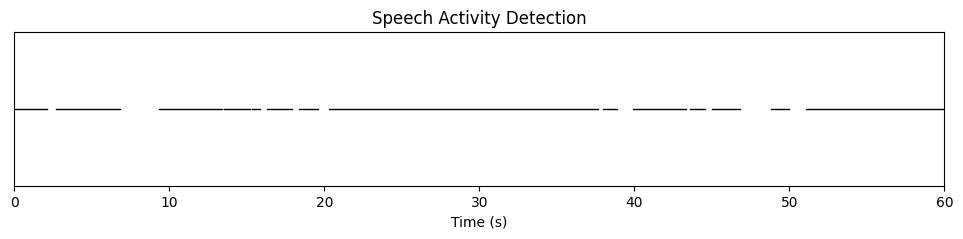

In [6]:
speech_timestamps = vad_inference(audio_path) # VAD inferencing
visualize_timestamps(speech_timestamps) # Visualize the speech timestamps
output_segments = print_timestamps(speech_timestamps) # Print the speech timestamps in a readable format
annotated_segments = parse_annotations_file(label_path) # Formate the label properly

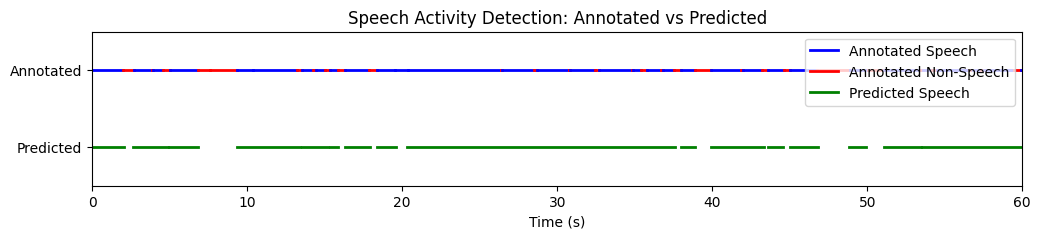

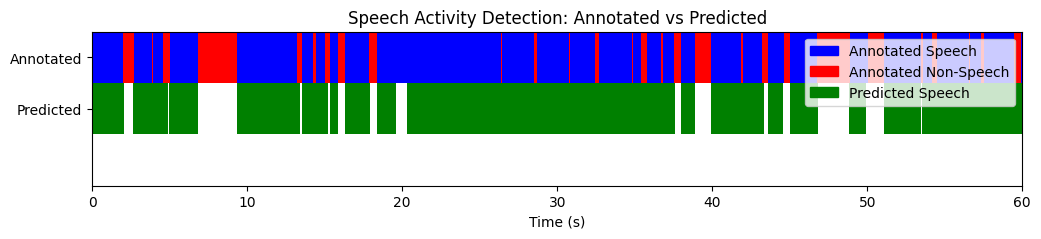

In [7]:
visualize_comparison(output_segments, annotated_segments)
visualize_comparison_stacked(output_segments, annotated_segments)

In [8]:
evaluation_results = evaluate_vad(output_segments, annotated_segments)
for result,value in list(evaluation_results.items()):
    print(result,"=", value)

precision = 0.9156262585581957
recall = 0.9793237131165194
f1_score = 0.9464044125299199
accuracy = 0.9141809698383603
specificity = 0.6914580265095729
fdr = 0.08437374144180428
miss_rate = 0.02067628688348051


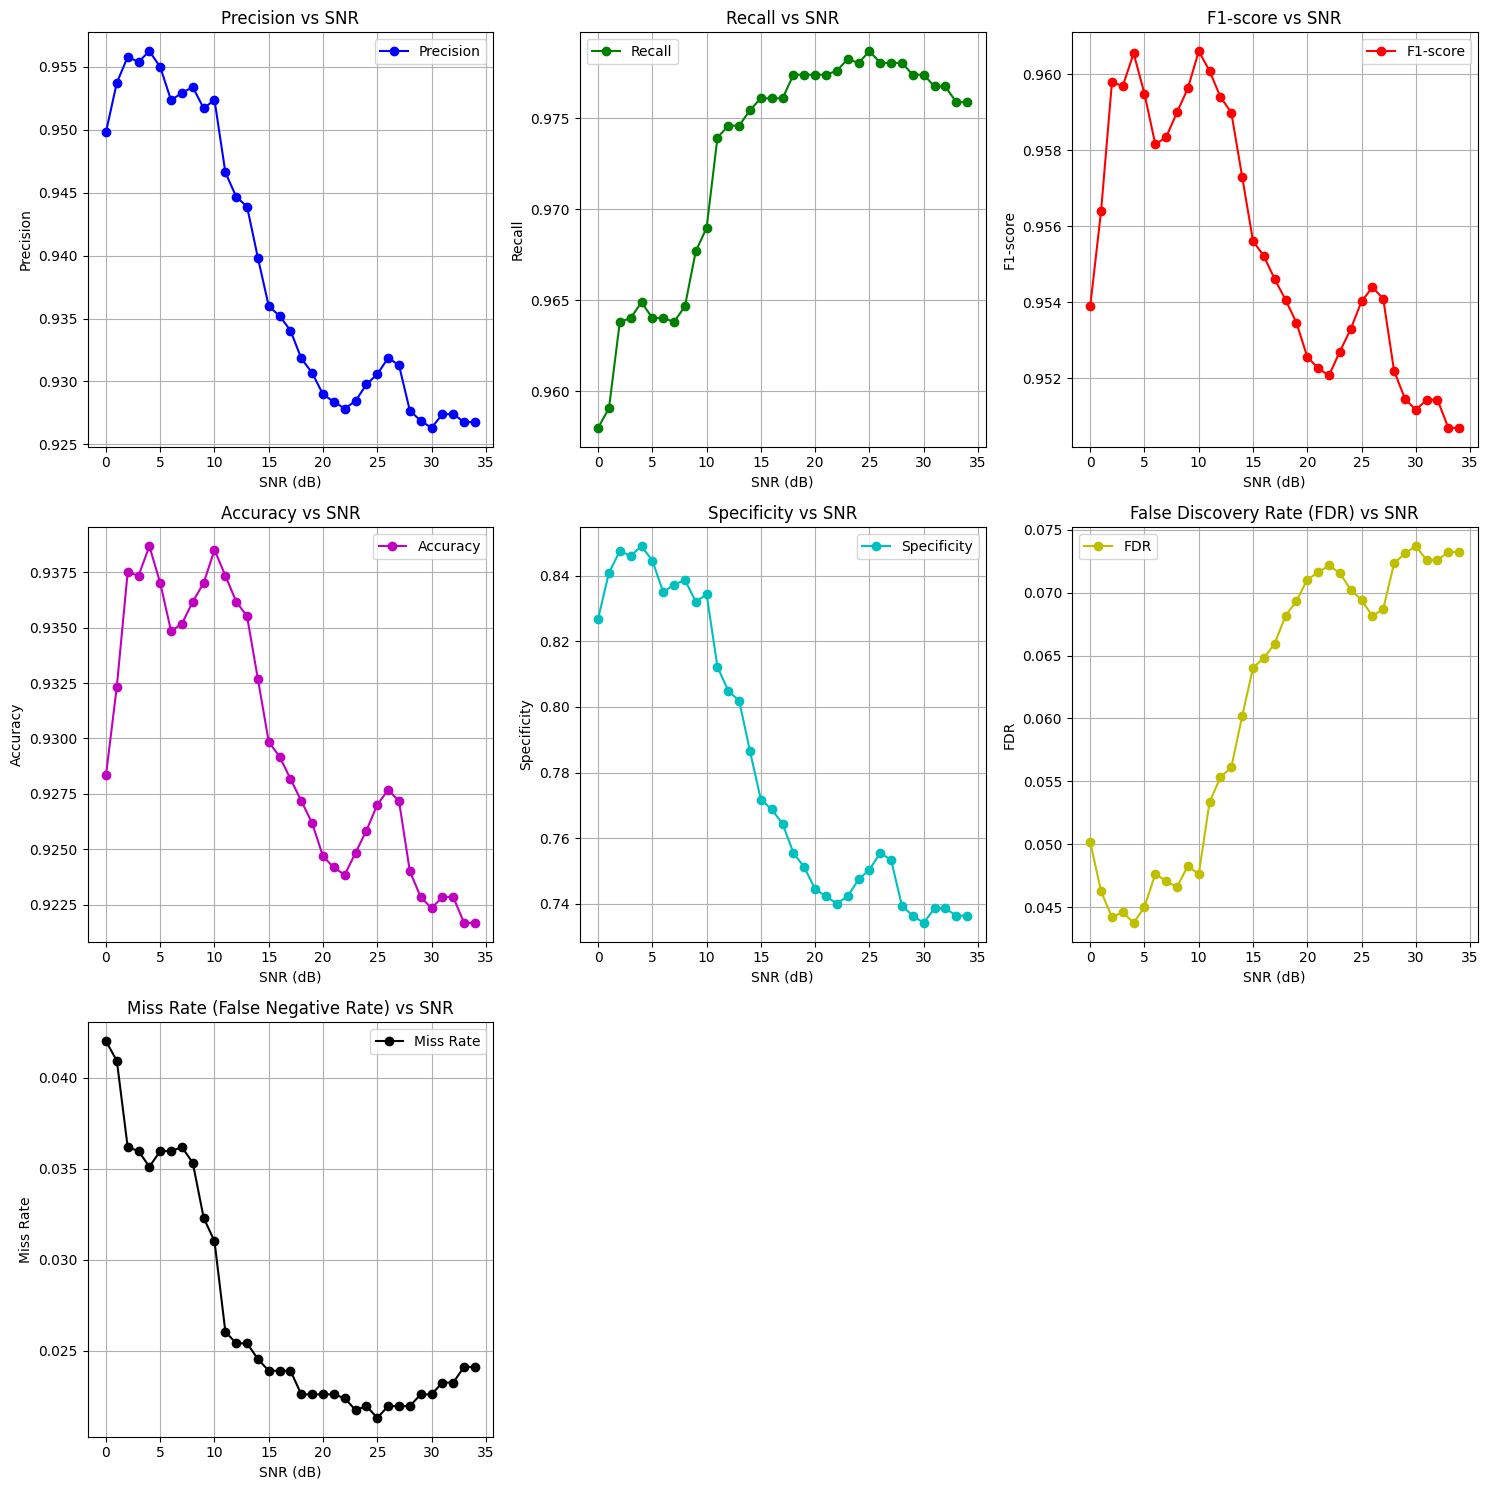

In [9]:
visualize_metrics_vs_SNR(0, 35)